In [1]:
from mxnet import ndarray as nd
from mxnet import autograd

num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(shape=y.shape)

In [2]:
print(X[0], y[0])


[ 0.23107235  0.30030754]
<NDArray 2 @cpu(0)> 
[ 3.64977074]
<NDArray 1 @cpu(0)>


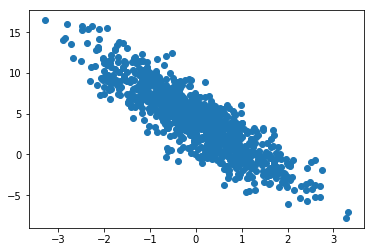

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(),y.asnumpy())
plt.show()

In [4]:
import random
batch_size = 10
def data_iter():
    # 产生一个随机索引
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size,num_examples)])
        yield nd.take(X, j), nd.take(y, j)

In [5]:
for data, label in data_iter():
    print(data, label)
    break


[[-1.30539978 -0.60691798]
 [ 1.7340399  -0.50702953]
 [ 1.51688695 -0.86844075]
 [ 1.44218373  1.22490478]
 [ 0.46260843 -0.60336095]
 [ 0.54254794 -0.1981228 ]
 [ 0.47513527  0.59216529]
 [ 0.15619713 -0.14186013]
 [ 0.2506429  -1.94705093]
 [-1.00427568 -2.03032255]]
<NDArray 10x2 @cpu(0)> 
[  3.66707349   9.40388775  10.19940853   2.90805197   7.17280197
   5.97901773   3.13678408   4.97730541  11.31468964   9.09963703]
<NDArray 10 @cpu(0)>


In [6]:
w = nd.random_normal(shape=(num_inputs, 1))
b = nd.zeros((1,))
params = [w, b]

In [7]:
params

[
 [[ 0.85240501]
  [ 0.79687113]]
 <NDArray 2x1 @cpu(0)>, 
 [ 0.]
 <NDArray 1 @cpu(0)>]

In [8]:
# 对这些参数求导来更新它们的值，使损失尽量减小；因此我们需要创建它们的梯度
for param in params:
    param.attach_grad()

In [9]:
def net(X):
    return nd.dot(X, w) + b

In [10]:
def square_loss(yhat, y):
    # 注意这里我们把y变形成yhat的形状来避免矩阵形状的自动转换
    return (yhat - y.reshape(yhat.shape)) ** 2

In [11]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [12]:
# 模型函数
def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2
# 绘制损失随训练次数降低的折线图，以及预测值和真实值的散点图
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()
    plt.show()

Epoch 0, batch 99. Moving avg of loss: 9.50101154805e-05. Average loss: 0.000094


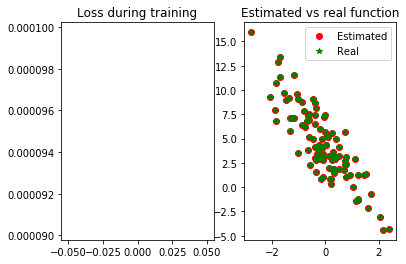

Epoch 1, batch 199. Moving avg of loss: 9.52167942493e-05. Average loss: 0.000093


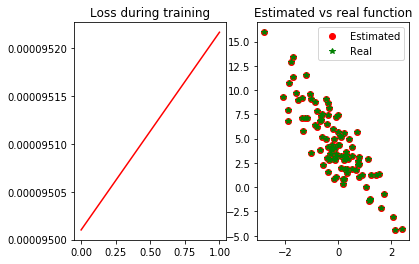

Epoch 2, batch 299. Moving avg of loss: 9.60150852567e-05. Average loss: 0.000094


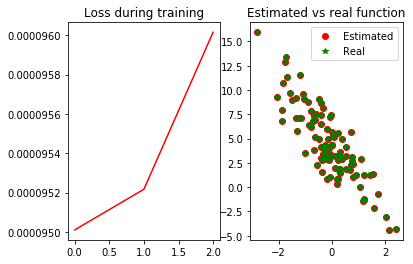

Epoch 3, batch 399. Moving avg of loss: 9.66829063621e-05. Average loss: 0.000095


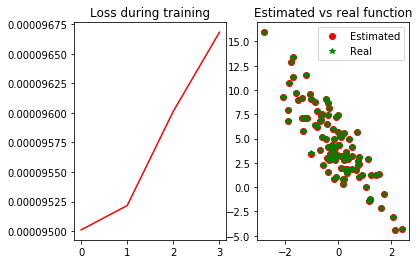

Epoch 4, batch 499. Moving avg of loss: 9.49989696606e-05. Average loss: 0.000095


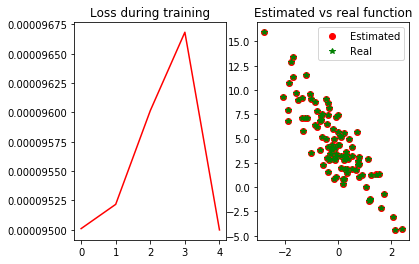

true_w: [2, -3.4], w: 
[[ 2.00046015]
 [-3.39768362]]
<NDArray 2x1 @cpu(0)>, true_b: 4.2, b: 
[ 4.20161152]
<NDArray 1 @cpu(0)>


In [17]:
epochs = 5
learning_rate = .01
niter = 0
losses = []
moving_loss = 0
smoothing_constant = .01

# 训练
for e in range(epochs):
    total_loss = 0

    for data, label in data_iter():
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        total_loss += nd.sum(loss).asscalar()

        # 记录每读取一个数据点后，损失的移动平均值的变化；
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)

        if (niter + 1) % 100 == 0:
            losses.append(est_loss)
            print("Epoch %s, batch %s. Moving avg of loss: %s. Average loss: %f" % (e, niter, est_loss, total_loss/num_examples))
            plot(losses, X)

print("true_w: {}, w: {}, true_b: {}, b: {}".format(true_w, w, true_b, b))

In [16]:
params

[
 [[ 2.00005031]
  [-3.40008283]]
 <NDArray 2x1 @cpu(0)>, 
 [ 4.20027828]
 <NDArray 1 @cpu(0)>]